In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rasterstats
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pyplot_themes as themes
from matplotlib.ticker import MaxNLocator
os.chdir(r'C:\Users\silas\kDrive\Projects\BA\python\geodata')

ModuleNotFoundError: No module named 'geopandas'

In [2]:
#importing demmand data
gas_lau1_con_all=pd.read_csv(r'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853197/gas_LA_stacked.csv', 
                            encoding = "ISO-8859-1", header=0, index_col=[1,3])
gas_lau1_con_all.iloc[:, 4:16]= gas_lau1_con_all.iloc[:,4:16].apply(pd.to_numeric, errors='coerce')

#import grided population data
with rasterio.open(r'population-uk.tif') as pop_grid:
        array = pop_grid.read(1)
        crs = pop_grid.crs
        affine = pop_grid.transform
        
#importing Calliope model zones 
calliope_zones=gpd.read_file(r'calliope_zones\zones.shp', indexcol=0)

#importing shapefile of local authorities
uk_lau1_units=gpd.read_file(r'Local_Authority_Districts__December_2017__Boundaries_in_Great_Britain')
uk_lau1_units = uk_lau1_units.set_index("lad17nm", drop=True)

#only select data from 2014
gas_lau1_con_2014= gas_lau1_con_all.query('Year == 2014').reset_index()

#join on shapefile
gas_lau1_con_2014.set_index('la.name', inplace=True)
lau_gas_shape = uk_lau1_units.join(gas_lau1_con_2014)

In [3]:
#overlay
lau_zones = gpd.overlay(calliope_zones.to_crs(crs), lau_gas_shape.to_crs(crs), how='intersection', keep_geom_type=False)

#calculate population per snippet
pop = rasterstats.zonal_stats(lau_zones.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
lau_zones['population'] = [i['sum'] for i in pop]

# weighted average according to population
lau_zones = lau_zones.set_index(['Name_1', 'lad17cd'], drop=False)
weights = lau_zones.population.div(lau_zones.sum(level='lad17cd').population)
lau_zones['domestic_weighted']=lau_zones['domestic.sales.gwh']*weights
lau_zones['non-domestic_weighted']=lau_zones['non.domestic.sales.gwh']*weights

In [4]:
#sum up per zone and export
gas_per_zone=lau_zones.loc[:,['domestic_weighted','non-domestic_weighted']].groupby(level='Name_1').sum()
gas_per_zone.to_csv(r'C:\Users\silas\kDrive\Projects\BA\python\heat profiles\gas_per_Zone_2014.csv')

#add shapes for plotting
calliope_zones.set_index('Name_1', inplace=True)
gas_per_zone=calliope_zones.join(gas_per_zone)
gas_per_zone['total']=gas_per_zone.sum(axis=1)

In [5]:
#import electricity data
elec_zones=gpd.read_file('elec_zones.shp', index_col=0, header=0)
elec_lau1 =gpd.read_file('elec_lau1.shp', index_col=0, header=0)

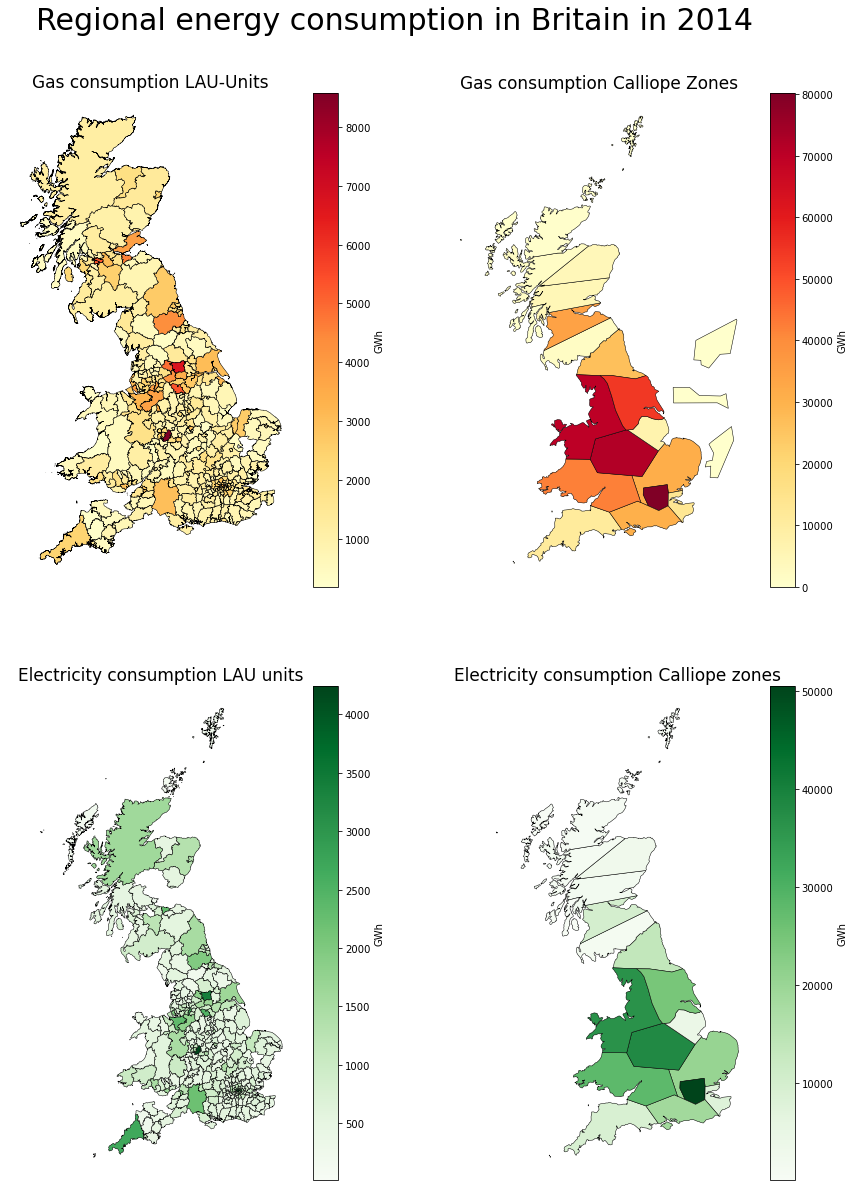

In [6]:
#plot gas and electricity consumption in 2014
fig, ax = plt.subplots(2,2, figsize=(15, 20))
cols_gas='YlOrRd'
cols_elec='Greens'

lau_gas_shape.plot('total.gwh', ax=ax[0,0], linewidth=0.5,legend=True, cmap=cols_gas, edgecolor='black',
                  legend_kwds={'label': "GWh", 'orientation': "vertical"})

ax[0,0].set_title('Gas consumption LAU-Units', size=17)
ax[0,0].axis('off')
gas_per_zone.plot('total', legend=True, ax=ax[0,1], linewidth=0.5, cmap=cols_gas, edgecolor='black',
                  legend_kwds={'label': "GWh", 'orientation': "vertical"})
ax[0,1].set_title('Gas consumption Calliope Zones', size=17, y=1)
ax[0,1].axis('off')

elec_lau1.plot('Total cons', legend=True, ax=ax[1,0], linewidth=0.5, cmap=cols_elec, edgecolor='black',
                  legend_kwds={'label': "GWh", 'orientation': "vertical"})
ax[1,0].set_title('Electricity consumption LAU units', size=17)
ax[1,0].axis('off')

elec_zones.plot('Total cons', ax=ax[1,1], linewidth=0.5,legend=True, cmap=cols_elec, edgecolor='black',
                  legend_kwds={'label': "GWh", 'orientation': "vertical"})
ax[1,1].set_title('Electricity consumption Calliope zones', size=17)
ax[1,1].axis('off')
fig.suptitle('Regional energy consumption in Britain in 2014', fontsize=30, x=0.5, y=0.94)


plt.savefig(r'C:\Users\silas\kDrive\Projects\BA\writing\plots\elec&gas_con.png')

In [1]:
#plot electrictity demand from 2000 onwards
elec_timeseries=pd.read_csv(r'C:\Users\silas\kDrive\Projects\BA\python\Electricity\elec_timeseries.csv',index_col=0, header=0)
gas_anual=gas_lau1_con_all.groupby('Year').sum()/1000
themes.theme_fivethirtyeight()

fig, ax=plt.subplots(1,1, figsize=(10, 7))
gas_anual.plot(y='total.gwh', color='#31a354', linewidth=3, ax=ax, label='Gas consumption')
elec_timeseries.plot(y='Consumption in tW', color='#e6550d', ax=ax, linewidth=3, label='Electricity consumption')
ax.set_title('Yearly energy consumption in Britain', size=25)
ax.set_ylabel('TWh', size=15)
ax.set_xlabel('')
ax.set_ylim([0,700])
ax.set_xlim([2006, 2018])
ax.yaxis.set_major_locator(MaxNLocator(prune='both'))

plt.savefig(r'C:\Users\silas\kDrive\Projects\BA\writing\plots\yearly_energy_con.png', transparent=True)

NameError: name 'pd' is not defined